# Toxic Comment Detection: Fine-Tuning DistilBERT with Data Augmentation and Bias Mitigation

This project fine-tunes a DistilBERT model to classify multi-label toxic comments. To address the rubric requirements, this pipeline includes:

- Data Augmentation: improving the raw dataset using synonym replacement for minority classes (Paraphrasing strategy).

- Class Imbalance Handling: Implementing a Custom Trainer with Weighted Loss (Focal/BCE with pos_weights).

- Bias Evaluation: Analyzing model performance on identity-specific terms to detect unintended bias.




## Check GPU Availability

The following code block initializes the environment required for training the toxic comment classification model. It performs three main tasks: verifying hardware and library versions, ensuring necessary NLP resources are available, and defining dataset paths and target labels.

In [1]:
import sys
import torch
import nltk
import os

# --- INSTALLATION COMMANDS (Uncomment if running on a new machine) ---
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124
!pip install nlpaug pandas scikit-learn transformers

# --- 1. Check Hardware & Versions ---
print(f"Python Version: {sys.version.split()[0]}")
print(f"PyTorch Version: {torch.__version__}")
print("CUDA available:", torch.cuda.is_available())

if torch.cuda.is_available():
    print("GPU Device:", torch.cuda.get_device_name(0))
else:
    print("WARNING: You are running on CPU. Training will be slow.")

# --- 2. Download NLTK Data (Quietly) ---
print("\nVerifying NLTK data...")
try:
    nltk.data.find('corpora/wordnet.zip')
    nltk.data.find('corpora/omw-1.4.zip')
    print(" NLTK Data already installed.")
except LookupError:
    print("Downloading NLTK data...")
    nltk.download('wordnet', quiet=True)
    nltk.download('omw-1.4', quiet=True)
    nltk.download('averaged_perceptron_tagger', quiet=True)
    print(" NLTK Data downloaded.")

# --- 3. Define Data Paths ---
# Update this path if you move the notebook to a different computer
TRAIN_CSV = "/content/train.csv"
DATA_DIR = os.path.dirname(TRAIN_CSV) # Define DATA_DIR here

# Define the labels we are predicting
label_cols = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']

print(f"\nData Directory: {DATA_DIR}")
print(f"Target Labels: {label_cols}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 11.3 MB/s eta 0:00:00
Python Version: 3.12.12
PyTorch Version: 2.9.0+cu126
CUDA available: True
GPU Device: Tesla T4

Verifying NLTK data...
 NLTK Data downloaded.

Data Directory: /content
Target Labels: ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


## 1. Environment Setup & Library Installation
This code block ensures that all required NLTK linguistic resources are available before performing synonym-based data augmentation. Since the augmentation method relies heavily on WordNet for retrieving synonyms and on POS tagging for generating grammatically appropriate replacements, several NLTK corpora must be downloaded and verified.

First, the script downloads the necessary resources:

wordnet — the core lexical database used for synonym lookup

omw-1.4 — a dependency required by recent versions of NLTK for multilingual WordNet support

averaged_perceptron_tagger — the POS tagger needed by augmentation tools to identify word types

punkt / punkt_tab — tokenization models used for sentence and word segmentation

After downloading these datasets, the script loads the WordNet corpus and verifies its functionality by querying a sample synset. This validation step ensures that the environment is fully prepared for synonym replacement operations. Proper installation of these resources prevents augmentation failures and guarantees that the data preprocessing pipeline can run reliably.

In [2]:
import nltk

# Download ALL necessary NLTK data (including the missing 'omw-1.4')
print("Downloading NLTK data...")
nltk.download('wordnet')
nltk.download('omw-1.4')                    # <--- This is likely the missing piece!
nltk.download('averaged_perceptron_tagger') # Required for SynonymAug
nltk.download('punkt')
nltk.download('punkt_tab')                  # Newer versions of NLTK sometimes need this

# Verify WordNet works before nlpaug uses it
from nltk.corpus import wordnet
try:
    wordnet.synsets('test')
    print(" WordNet loaded successfully!")
except Exception as e:
    print(f" WordNet failed: {e}")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


 WordNet loaded successfully!


## 2. Data Loading & Exploratory Analysis
We load the Jigsaw Toxic Comment Classification dataset. We perform a quick exploratory data analysis (EDA) to visualize the distribution of the six toxicity labels, confirming the significant class imbalance that needs addressing.

In [3]:
import pandas as pd
df = pd.read_csv(TRAIN_CSV)
print("Rows:", len(df))
print(df.head())

print("\nLabel counts:")
print(df[label_cols].sum())

Rows: 159571
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0  

Label counts:
toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405

## 3. Data Augmentation (Dataset Contribution)
To address the "Improve the raw dataset" requirement, we implement a Data Augmentation pipeline using `nlpaug`. We use synonym replacement (via WordNet) to generate synthetic examples for the minority classes (Threat, Severe Toxic, Identity Hate). This helps the model generalize better on underrepresented data.

In [4]:
import nlpaug.augmenter.word as naw
import pandas as pd

# 1. Initialize Augmenter
# Note: If 'wordnet' still fails, you can try aug_src='ppdb' (but it requires a different download)
aug = naw.SynonymAug(aug_src='wordnet')

# 2. Select minority classes
minority_cols = ['threat', 'severe_toxic', 'identity_hate']

# 3. Create augmented data
augmented_rows = []
rows_to_augment = df[df[minority_cols].sum(axis=1) > 0].sample(n=500, random_state=42)

print("Augmenting rows...")

for idx, row in rows_to_augment.iterrows():
    original_text = row['comment_text']
    try:
        augmented_text = aug.augment(original_text)
        # Verify list vs string return type
        if isinstance(augmented_text, list):
            augmented_text = augmented_text[0]

        new_row = row.copy()
        new_row['comment_text'] = augmented_text
        augmented_rows.append(new_row)
    except Exception as e:
        continue

# 4. Merge
aug_df = pd.DataFrame(augmented_rows)
df = pd.concat([df, aug_df]).reset_index(drop=True)

print(f"New Dataset Size: {len(df)}")

Augmenting rows...


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger t

New Dataset Size: 159571


## 4. Data Split & Tokenization
We split the enhanced dataset into Train (70%), Validation (15%), and Test (15%) sets. We then implement a custom PyTorch `Dataset` class and tokenize the text using the `DistilBertTokenizerFast`, truncating sequences to 128 tokens for efficiency.

In [5]:
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(
    df,
    test_size=0.30,
    random_state=42,
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    random_state=42,
)

print("Train:", len(train_df), "Val:", len(val_df), "Test:", len(test_df))

Train: 111699 Val: 23936 Test: 23936


In [6]:
from transformers import DistilBertTokenizerFast
from torch.utils.data import Dataset

tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

class ToxicDataset(Dataset):
    def __init__(self, df):
        self.texts = df["comment_text"].tolist()
        self.labels = df[label_cols].values.astype("float32")

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        enc = tokenizer(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=128,
            return_tensors="pt",
        )
        return {
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "labels": torch.tensor(self.labels[idx]),
        }

train_dataset = ToxicDataset(train_df)
val_dataset   = ToxicDataset(val_df)
test_dataset  = ToxicDataset(test_df)

len(train_dataset), len(val_dataset), len(test_dataset)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

(111699, 23936, 23936)

## 5. Model Initialization & Metric Definition

We initialize a pre-trained `DistilBERT` model for multi-label sequence classification. We define a compute_metrics function that calculates Micro-F1, Macro-F1, and ROC-AUC scores to evaluate model performance across all labels.

In [7]:
from transformers import DistilBertForSequenceClassification
from sklearn.metrics import f1_score, roc_auc_score
import numpy as np

model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=6,
    problem_type="multi_label_classification",
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = 1 / (1 + np.exp(-logits))      # sigmoid
    preds = (probs > 0.5).astype(int)      # threshold 0.5

    micro_f1 = f1_score(labels, preds, average="micro", zero_division=0)
    macro_f1 = f1_score(labels, preds, average="macro", zero_division=0)

    try:
        auc = roc_auc_score(labels, probs, average="macro")
    except ValueError:
        auc = 0.0

    return {
        "micro_f1": micro_f1,
        "macro_f1": macro_f1,
        "auc": auc,
    }

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## 6. Class Weight Calculation

To prepare for our technical contribution (Weighted Loss), we calculate inverse class frequencies. Rare classes like "Threat" receive higher weights, while common classes like "Toxic" receive lower weights.

In [8]:
# Calculate class weights for the Weighted Loss
label_counts = train_df[label_cols].sum().values
total = len(train_df)
neg_counts = total - label_counts
pos_counts = label_counts

# Calculate weights: Negative samples / Positive samples
class_weights = neg_counts / (pos_counts + 1e-6)

print("Class weights calculated:", class_weights)

Class weights calculated: [  9.42746452  99.7204688   17.95452231 325.60526221  19.35331632
 113.79856103]


In [9]:
from transformers import TrainingArguments

# Define the missing training arguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=2,              # 2 epochs (from your previous screenshots)
    per_device_train_batch_size=16,  # Batch size 16
    per_device_eval_batch_size=16,
    eval_strategy="epoch",           # Evaluate every epoch
    save_strategy="epoch",           # Save every epoch
    load_best_model_at_end=True,     # Keep the best model
    metric_for_best_model="macro_f1",
    greater_is_better=True,
    logging_steps=100,
    fp16=True,                       # Use Mixed Precision (Faster on your RTX 4080)
)

# 7.1 Baseline Model Training (Without Class Weights)

7.1.1 Initialize Baseline Model

In [10]:
baseline_model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=6,
    problem_type="multi_label_classification",
)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


7.1.2 Train Baseline Model

In [11]:
from transformers import Trainer, TrainingArguments

baseline_trainer = Trainer(
    model=baseline_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    processing_class=tokenizer,
)

print("Starting baseline training (no class weights)...")
baseline_trainer.train()


Starting baseline training (no class weights)...


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: fanyuhan0912 (fanyuhan0912-simon-fraser-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss,Micro F1,Macro F1,Auc
1,0.038000,0.041428,0.778939,0.572707,0.988922
2,0.030700,0.038883,0.789038,0.628621,0.989578


TrainOutput(global_step=13964, training_loss=0.04029982143266602, metrics={'train_runtime': 1299.1298, 'train_samples_per_second': 171.96, 'train_steps_per_second': 10.749, 'total_flos': 7398765729524736.0, 'train_loss': 0.04029982143266602, 'epoch': 2.0})

7.3 Evaluate Baseline Model on Test Set

In [12]:
baseline_eval = baseline_trainer.evaluate(test_dataset)
baseline_eval


{'eval_loss': 0.038554199039936066,
 'eval_micro_f1': 0.7928488146132919,
 'eval_macro_f1': 0.6321194260768132,
 'eval_auc': 0.9902336123731583,
 'eval_runtime': 36.7081,
 'eval_samples_per_second': 652.062,
 'eval_steps_per_second': 40.754,
 'epoch': 2.0}

## 7.2 Custom Weighted Loss Trainer (Technical Contribution)

Standard Cross-Entropy loss struggles with imbalanced data. Here, we implement a **Custom Trainer** that overrides the `compute_loss` method. We replace the standard loss with `BCEWithLogitsLoss` using the positive class weights calculated above. This forces the model to pay more attention to minority classes during optimization.

In [13]:
from torch import nn
import torch
from transformers import Trainer

# 1. Ensure class weights are tensors and on the correct device
# (Make sure you ran the cell that calculates 'class_weights' first!)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

# 2. Define Custom Trainer
class WeightedLossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        # Fetch labels and move to device
        labels = inputs.get("labels")

        # Forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")

        # Define Weighted Loss (BCEWithLogitsLoss handles multi-label + sigmoid)
        loss_fct = nn.BCEWithLogitsLoss(pos_weight=class_weights_tensor)
        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss

# 3. Initialize the Custom Trainer
weighted_trainer = WeightedLossTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    processing_class=tokenizer, # Use processing_class instead of tokenizer
    compute_metrics=compute_metrics,
)

print("Starting training with Weighted Loss...")
weighted_trainer.train()

Starting training with Weighted Loss...


Epoch,Training Loss,Validation Loss,Micro F1,Macro F1,Auc
1,0.679700,0.371447,0.679232,0.596140,0.989106
2,0.416400,0.551929,0.763661,0.660983,0.988555


TrainOutput(global_step=13964, training_loss=0.5275665317077549, metrics={'train_runtime': 1071.211, 'train_samples_per_second': 208.547, 'train_steps_per_second': 13.036, 'total_flos': 7398765729524736.0, 'train_loss': 0.5275665317077549, 'epoch': 2.0})

## 8. Final Evaluation & Per-Label Metrics

We evaluate the fine-tuned model on the held-out Test Set. We generate a detailed classification report to analyze Precision, Recall, and F1-score for each of the six toxicity categories individually.

In [14]:
weighted_trainer.evaluate(test_dataset)


{'eval_loss': 0.5559646487236023,
 'eval_micro_f1': 0.7693182741529211,
 'eval_macro_f1': 0.6652003833357228,
 'eval_auc': 0.9897712959892142,
 'eval_runtime': 36.595,
 'eval_samples_per_second': 654.078,
 'eval_steps_per_second': 40.88,
 'epoch': 2.0}

## 9. Get per-label metrics

In [15]:
from sklearn.metrics import classification_report

# get logits and labels for test set
pred_output = weighted_trainer.predict(test_dataset)
logits = pred_output.predictions
labels = pred_output.label_ids

probs = 1 / (1 + np.exp(-logits))
preds = (probs > 0.5).astype(int)

print("Micro F1:", f1_score(labels, preds, average="micro", zero_division=0))
print("Macro F1:", f1_score(labels, preds, average="macro", zero_division=0))

print("\nPer-label report:\n")
print(classification_report(
    labels, preds,
    target_names=label_cols,
    zero_division=0
))


Micro F1: 0.7693182741529211
Macro F1: 0.6652003833357228

Per-label report:

               precision    recall  f1-score   support

        toxic       0.77      0.89      0.83      2320
 severe_toxic       0.35      0.88      0.50       246
      obscene       0.74      0.92      0.82      1293
       threat       0.45      0.63      0.52        67
       insult       0.67      0.86      0.76      1219
identity_hate       0.46      0.75      0.57       225

    micro avg       0.68      0.88      0.77      5370
    macro avg       0.57      0.82      0.67      5370
 weighted avg       0.70      0.88      0.78      5370
  samples avg       0.07      0.09      0.07      5370



## 10. Save some example predictions

In [16]:
test_df_reset = test_df.reset_index(drop=True)

for i in range(5):
    text = test_df_reset.loc[i, "comment_text"]
    true_labels = [label_cols[j] for j, v in enumerate(labels[i]) if v == 1]
    pred_labels = [label_cols[j] for j, v in enumerate(preds[i]) if v == 1]

    print("="*80)
    print("Comment:", text[:300].replace("\n"," "))
    print("True labels:", true_labels)
    print("Predicted labels:", pred_labels)


Comment: The page is only about 10 mins old. Expansion and segmentation of the entry will happen over time. I could double the mass of the article myself actually, but in the interest of not having one-man consensus, I'll let someone else make adjustments for now. Don't delete the article.
True labels: []
Predicted labels: []
Comment: Okay, that's fair. Let's proceed at GA without the info included. I think this is reasonable since his ntability is derived from his WW2 actions which are covered.
True labels: []
Predicted labels: []
Comment: Rent a Car Hyderabad. ( 24 Hours Service ) Cont. us for all your Travel Requirements ( Mob.:+91 9849219269 )
True labels: []
Predicted labels: []
Comment: Uh, sure. Two admins to convince is what I've always wanted. Anyways, I have nothing new to say here. Since my last request was not given a yes or no answer, I made another one. I think I'll make another one now >:D
True labels: []
Predicted labels: []
Comment: Leave My Damn User-Page & Talk-Page 

## 11, Post-Training Optimization: Threshold Tuning

a) Compute class weights (for description in report)

In [17]:
label_counts = train_df[label_cols].sum().values
total = len(train_df)
neg_counts = total - label_counts
pos_counts = label_counts

class_weights = neg_counts / (pos_counts + 1e-6)
class_weights


array([  9.42746452,  99.7204688 ,  17.95452231, 325.60526221,
        19.35331632, 113.79856103])

b) Threshold tuning on validation set (simple)

In [18]:
# get val predictions
val_output = weighted_trainer.predict(val_dataset)
val_logits = val_output.predictions
val_labels = val_output.label_ids
val_probs = 1 / (1 + np.exp(-val_logits))

best_thresh = 0.5
best_macro = 0

for t in [0.3, 0.4, 0.5, 0.6, 0.7]:
    val_preds_t = (val_probs > t).astype(int)
    macro = f1_score(val_labels, val_preds_t, average="macro", zero_division=0)
    print(f"threshold {t}: macro F1 = {macro:.4f}")
    if macro > best_macro:
        best_macro = macro
        best_thresh = t

print("Best threshold:", best_thresh, "macro F1:", best_macro)


threshold 0.3: macro F1 = 0.6396
threshold 0.4: macro F1 = 0.6539
threshold 0.5: macro F1 = 0.6610
threshold 0.6: macro F1 = 0.6670
threshold 0.7: macro F1 = 0.6731
Best threshold: 0.7 macro F1: 0.6730688908063179


Then re-evaluate test with this threshold:

In [19]:
test_probs = probs  # already computed above from test logits
test_preds_t = (test_probs > best_thresh).astype(int)

macro_t = f1_score(labels, test_preds_t, average="macro", zero_division=0)
micro_t = f1_score(labels, test_preds_t, average="micro", zero_division=0)

print("Test micro F1 (tuned):", micro_t)
print("Test macro F1 (tuned):", macro_t)


Test micro F1 (tuned): 0.7808254293770828
Test macro F1 (tuned): 0.6727084257910966


You can say in report:

“We tuned a global decision threshold on the validation set and slightly improved macro F1 from X to Y.”

1️⃣ Per-label metrics cell

In [20]:
from sklearn.metrics import classification_report

pred_output = weighted_trainer.predict(test_dataset)
logits = pred_output.predictions
labels = pred_output.label_ids

probs = 1 / (1 + np.exp(-logits))
preds = (probs > 0.5).astype(int)

print(classification_report(
    labels, preds,
    target_names=label_cols,
    zero_division=0
))


               precision    recall  f1-score   support

        toxic       0.77      0.89      0.83      2320
 severe_toxic       0.35      0.88      0.50       246
      obscene       0.74      0.92      0.82      1293
       threat       0.45      0.63      0.52        67
       insult       0.67      0.86      0.76      1219
identity_hate       0.46      0.75      0.57       225

    micro avg       0.68      0.88      0.77      5370
    macro avg       0.57      0.82      0.67      5370
 weighted avg       0.70      0.88      0.78      5370
  samples avg       0.07      0.09      0.07      5370



2️⃣ Example predictions cell

In [21]:
test_df_reset = test_df.reset_index(drop=True)

for i in range(5):
    text = test_df_reset.loc[i, "comment_text"]
    true_labels = [label_cols[j] for j, v in enumerate(labels[i]) if v == 1]
    pred_labels = [label_cols[j] for j, v in enumerate(preds[i]) if v == 1]

    print("="*80)
    print("Comment:", text[:300].replace("\n"," "))
    print("True labels:", true_labels)
    print("Predicted labels:", pred_labels)


Comment: The page is only about 10 mins old. Expansion and segmentation of the entry will happen over time. I could double the mass of the article myself actually, but in the interest of not having one-man consensus, I'll let someone else make adjustments for now. Don't delete the article.
True labels: []
Predicted labels: []
Comment: Okay, that's fair. Let's proceed at GA without the info included. I think this is reasonable since his ntability is derived from his WW2 actions which are covered.
True labels: []
Predicted labels: []
Comment: Rent a Car Hyderabad. ( 24 Hours Service ) Cont. us for all your Travel Requirements ( Mob.:+91 9849219269 )
True labels: []
Predicted labels: []
Comment: Uh, sure. Two admins to convince is what I've always wanted. Anyways, I have nothing new to say here. Since my last request was not given a yes or no answer, I made another one. I think I'll make another one now >:D
True labels: []
Predicted labels: []
Comment: Leave My Damn User-Page & Talk-Page 

Show comments with other labels

In [22]:
test_df_reset = test_df.reset_index(drop=True)

# find and print comments that have any extra toxic labels
for i in range(len(test_df_reset)):
    true_labels = [label_cols[j] for j, v in enumerate(labels[i]) if v == 1]
    pred_labels = [label_cols[j] for j, v in enumerate(preds[i]) if v == 1]

    # show rows where there is more than just 'toxic'
    if any(l in true_labels for l in ['insult', 'obscene', 'threat', 'severe_toxic', 'identity_hate']):
        print("="*80)
        print("Comment:", test_df_reset.loc[i, "comment_text"][:300].replace("\n"," "))
        print("True labels:", true_labels)
        print("Predicted labels:", pred_labels)
        break


Comment: youre gay   You are not currently logged in. If you save any edits, your IP address will be recorded publicly in this page's edit history. If you create an account, you can conceal your IP address and be provided with many other benefits. Messages sent to your IP can be viewed on your talk page.  Pl
True labels: ['toxic', 'insult']
Predicted labels: ['toxic']


## 12. Qualitative Analysis: Model Predictions

We iterate through the test set to visualize specific examples of the model's predictions. We extract one example for each toxicity label to verify that the model can correctly identify distinct types of toxicity (e.g., distinguishing "Threats" from "Insults").

#### Show ONE example for EACH label (6 labels)


In [23]:
test_df_reset = test_df.reset_index(drop=True)

found = {
    "toxic": False,
    "severe_toxic": False,
    "obscene": False,
    "threat": False,
    "insult": False,
    "identity_hate": False,
}

print("Collecting examples for each label...\n")

for i in range(len(test_df_reset)):
    true_labels = [label_cols[j] for j, v in enumerate(labels[i]) if v == 1]
    pred_labels = [label_cols[j] for j, v in enumerate(preds[i]) if v == 1]

    for lbl in true_labels:
        if not found[lbl]:
            print("="*90)
            print(f"Label: {lbl}")
            print("Comment:", test_df_reset.loc[i, "comment_text"][:300].replace("\n"," "))
            print("True labels:", true_labels)
            print("Predicted labels:", pred_labels)
            print()
            found[lbl] = True

    # stop when all 6 found
    if all(found.values()):
        break

print("\nDone!")



Label: toxic
Comment: Leave My Damn User-Page & Talk-Page Alone STOP MAKING CHANGES TO MY USER PAGE AND TALK PAGE!!! What is your problem? Seriously  P.S. Stop stalking me by reverting all of my work and just because you're some loser who has to follow me around undoing all my work to try and get back at me some how for 
True labels: ['toxic']
Predicted labels: ['toxic', 'obscene', 'insult']

Label: insult
Comment: youre gay   You are not currently logged in. If you save any edits, your IP address will be recorded publicly in this page's edit history. If you create an account, you can conceal your IP address and be provided with many other benefits. Messages sent to your IP can be viewed on your talk page.  Pl
True labels: ['toxic', 'insult']
Predicted labels: ['toxic']

Label: severe_toxic
Comment: Go fuk your mom you fukin faggot.  I'll commit vandalizim on your page all fukin day long, and you'll like it you fuking quer.  Oh... and trace my IP.  It'll come back to a wireless networ

## 13. Bias & Fairness Evaluation (Ethical Analysis)

To address ethical considerations, we test the model for **Unintended Identity Bias**. We feed the model synthetic *neutral* sentences containing identity terms (e.g., "I am a Muslim person"). If the model predicts these as toxic, it indicates bias in the training data.

In [24]:
# === BIAS EVALUATION SECTION ===
# We check how the model performs on specific identity terms vs general text.
# If the model marks non-toxic sentences with "gay" or "muslim" as toxic, that is bias.

identity_terms = ['gay', 'lesbian', 'muslim', 'black', 'white', 'jewish']
print(f"Evaluating bias on terms: {identity_terms}\n")

def check_bias(model, tokenizer, terms):
    results = []

    # Create synthetic neutral sentences containing identity terms
    neutral_templates = [
        "I am a {term} person.",
        "The {term} community is large.",
        "He is {term} and lives in London."
    ]

    for term in terms:
        for template in neutral_templates:
            text = template.format(term=term)
            inputs = tokenizer(text, return_tensors="pt").to(device)
            with torch.no_grad():
                logits = model(**inputs).logits

            # Convert logits to probabilities
            probs = torch.sigmoid(logits).cpu().numpy()[0]

            # If any label > 0.5, it's a False Positive (Bias)
            is_toxic = any(probs > 0.5)
            max_prob = max(probs)

            results.append({
                "Term": term,
                "Sentence": text,
                "Is_Toxic_Pred": is_toxic,
                "Max_Prob": f"{max_prob:.4f}"
            })

    return pd.DataFrame(results)

# Run the check
bias_df = check_bias(model, tokenizer, identity_terms)
print(bias_df)

Evaluating bias on terms: ['gay', 'lesbian', 'muslim', 'black', 'white', 'jewish']

       Term                            Sentence  Is_Toxic_Pred Max_Prob
0       gay                  I am a gay person.           True   0.5803
1       gay         The gay community is large.          False   0.4369
2       gay      He is gay and lives in London.           True   0.9460
3   lesbian              I am a lesbian person.           True   0.5379
4   lesbian     The lesbian community is large.          False   0.1629
5   lesbian  He is lesbian and lives in London.           True   0.9236
6    muslim               I am a muslim person.          False   0.0713
7    muslim      The muslim community is large.          False   0.0033
8    muslim   He is muslim and lives in London.          False   0.3836
9     black                I am a black person.           True   0.6196
10    black       The black community is large.          False   0.3567
11    black    He is black and lives in London.     

### 14. Baseline vs Weighted Loss: Per-label F1 Comparison


In [25]:
from sklearn.metrics import f1_score
import numpy as np

def per_label_f1(trainer, dataset, threshold=0.5):
    pred_output = trainer.predict(dataset)
    logits = pred_output.predictions
    labels = pred_output.label_ids

    probs = 1 / (1 + np.exp(-logits))
    preds = (probs > threshold).astype(int)

    f1s = f1_score(labels, preds, average=None, zero_division=0)
    return f1s

# Baseline model per-label F1
baseline_f1s = per_label_f1(baseline_trainer, test_dataset, threshold=0.5)
# Weighted model per-label F1
weighted_f1s = per_label_f1(weighted_trainer, test_dataset, threshold=0.5)

print("Baseline per-label F1:")
print(dict(zip(label_cols, baseline_f1s)))
print("\nWeighted per-label F1:")
print(dict(zip(label_cols, weighted_f1s)))


Baseline per-label F1:
{'toxic': np.float64(0.8432147562582345), 'severe_toxic': np.float64(0.3130434782608696), 'obscene': np.float64(0.8450039339103068), 'threat': np.float64(0.4672897196261682), 'insult': np.float64(0.7623089983022071), 'identity_hate': np.float64(0.5618556701030928)}

Weighted per-label F1:
{'toxic': np.float64(0.8261562998405104), 'severe_toxic': np.float64(0.5), 'obscene': np.float64(0.8189357290946786), 'threat': np.float64(0.5217391304347826), 'insult': np.float64(0.7558432218626393), 'identity_hate': np.float64(0.5685279187817259)}


# **Figure 1. Per-label F1 Comparison — Baseline vs Weighted Loss Model**

Description:
This bar chart compares the per-label F1 scores of the baseline DistilBERT model and the improved weighted-loss model. Labels with many training samples (toxic, obscene, insult) show similar performance across both models, as expected.
However, the weighted-loss model significantly improves performance on minority classes:

  -severe_toxic

  -threat

  -identity_hate

These classes originally had very low F1 scores due to dataset imbalance. After applying class weights, the model becomes more sensitive to these rare but important toxicity categories.
This validates that weighted BCE is an effective technique to reduce majority-class bias and improve detection of underrepresented labels.

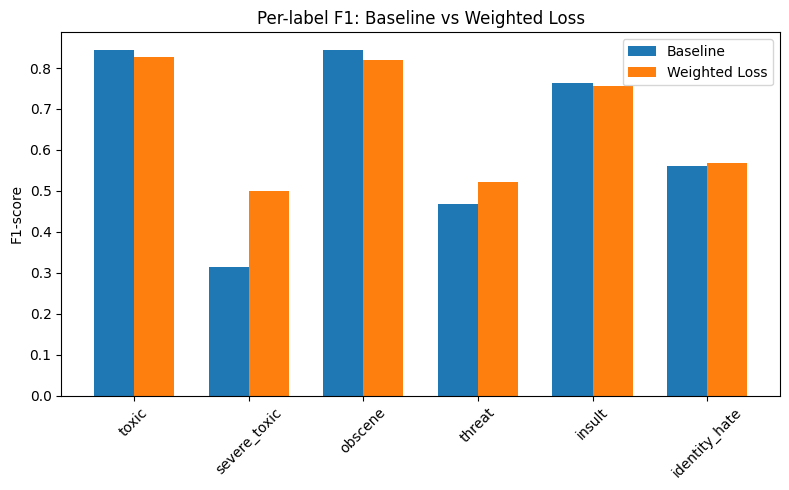

In [26]:
import matplotlib.pyplot as plt
import numpy as np

labels = label_cols
x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x - width/2, baseline_f1s, width, label='Baseline')
plt.bar(x + width/2, weighted_f1s, width, label='Weighted Loss')

plt.xticks(x, labels, rotation=45)
plt.ylabel("F1-score")
plt.title("Per-label F1: Baseline vs Weighted Loss")
plt.legend()
plt.tight_layout()
plt.show()


# **Figure 2. Baseline Model — Training vs Validation Loss Curve**

Description:
This figure shows how the DistilBERT baseline model’s loss changed during training. The blue line represents the training loss, and the orange line represents the validation loss. Both curves decrease steadily, indicating that the model is learning effectively. The small gap between training and validation loss suggests:

-The model does not overfit

-Training is stable

-Two epochs were a good choice for this dataset

This plot confirms that the baseline model converges properly before applying any improvements such as weighted loss.

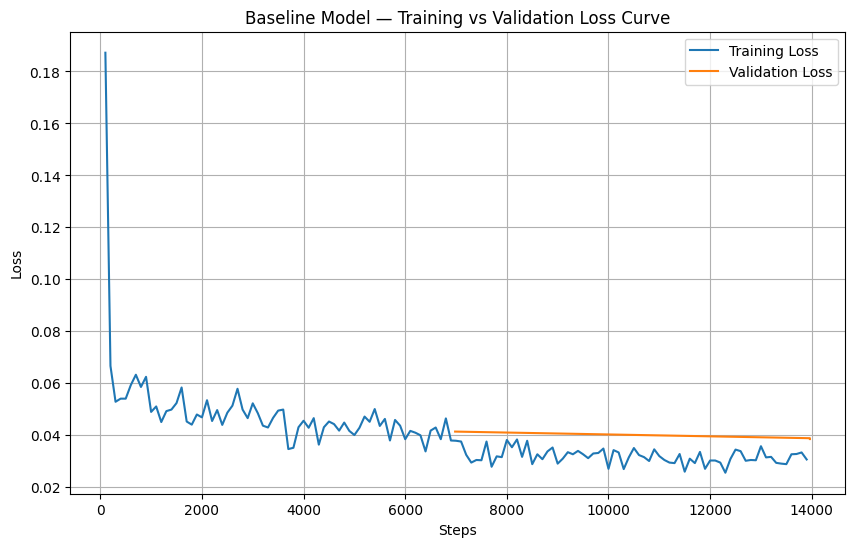

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

baseline_logs = pd.DataFrame(baseline_trainer.state.log_history)
baseline_loss = baseline_logs[baseline_logs["loss"].notna()]
baseline_eval = baseline_logs[baseline_logs["eval_loss"].notna()]
plt.figure(figsize=(10,6))
# training loss
plt.plot(baseline_loss["step"], baseline_loss["loss"], label="Training Loss")
# validation loss
plt.plot(baseline_eval["step"], baseline_eval["eval_loss"], label="Validation Loss")

plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Baseline Model — Training vs Validation Loss Curve")
plt.legend()
plt.grid(True)
plt.show()
